<a href="https://colab.research.google.com/github/troyfreed1/stock-prediction/blob/main/stock_prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Analysis of Macroeconomic Data for Stock Price Prediction**
*Troy Freed*

https://schaferkotter-freed.github.io/

*Misc. Installs*

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import yfinance as yf
import seaborn as sns
from sklearn.feature_extraction import DictVectorizer
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import cross_validate

# Introduction

When big economic shifts happen, like a sudden drop in unemployment or a steady rise in GDP, you’ll often see the markets move in response. Imagine knowing ahead of time that a tightening labor market could spark a jump in consumer stocks, or that an expected uptick in inflation might cause a pullback in technology shares. By tracking these macroeconomic trends, we can start to see the hidden connection between the broader economy and Wall Street.

Yet anyone who’s followed the stock market knows there’s more to it than just data: management's surprise decision, COVID, or even a political shakeup can send prices plummeting in seconds. These unexpected events makes pinpointing future stock prices practially impossible, but it doesn’t mean we can’t find meaningful signals. In this project, we will blend public economic data from FRED (Federal Reserve Economic Data) with past stock data from Yahoo Finance, using visualization and simple models to reveal which big picture indicators matter and how strongly they move the market.

#Project Goals

This project isn’t about being able to develop a perfect stock price predictor. Instead, the main goal is to visualize and quantify how much of the market’s movements can be explained by general economic shifts. We aim to reveal whether changes in things like unemployment, inflation, or GDP have significant correlation to stock market reactions, and to what degree.

To do that, we will pull together historical market data and economic indicators, then apply data-transformation techniques to reveal trends in past data. By using this knowledge we will then train a machine learning model that isolates this relationship and attempts predicting stock market prices, based on economic change predictions. Throughout the project, we hope to answer questions such as: How accurate is a prediction based mostly on economic data? Which indicators matter most? Are some industries more sensitive than others? And finally, could investors benefit from paying closer attention to big-picture signals?

# Collaboration Plan

Our collaboration plan is to connect once a week at minimum, whether that is in-person or through zoom, in order to make progress on the project. We also plan to communicate consistently through text in order to keep updated on any asynchronous progress we have made. We have set up a shared Google Colab which we will be using as our main venue of editing the project's content, alongside a shared GitHub repository where we both have collaborative access.

# Datasets

We’ll start by pulling historical stock market data from yfinance, a Python library for Yahoo Finance. With it, we can quickly download daily or monthly time series for the S&P 500, individual stocks, or entire sectors, everything from closing prices to trading volumes.

For the economics, we’ll extract FRED data, which contains decades of U.S. macro indicators: unemployment rates, housing prices, GDP growth, interest rates, and more. By merging these two sources into one dataset, we can see how economic shifts line up with market moves.


# S&P 500 Data

The following code uses the yfinance libary, pre-processing was simple and mainly involved renaming columns and removing missing values. This library will help us extract data relating to the S&P 500. The S&P 500 includes the 500 largest companies on the stock market. Because these companies are from various different industries, it provides a good indicator on how the overall economy is performing. Below, we plotted the closing prices of the S&P 500 from when they started in 1957 to present day. By looking at this graph we can get ideas of economy performance over the years, with the graph lining up with events stuch as a drop in the 2008 economic crisis or the sharp decrease in 2020 due to COVID.

An interesting statistic from this is that 50th percentile is actually at a close price of ~360.16, highlighting just how exponential the stock price has grown within the past ~25 years.


/tmp/ipython-input-1142119914.py:5: FutureWarning: YF.download() has changed argument auto_adjust default to True
  sp500_data = yf.download("^GSPC", start=start_date, end=end_date)
[*********************100%***********************]  1 of 1 completed


                                Date  SP500_Close_Price
count                          17117       17117.000000
mean   1991-01-07 17:55:43.833615744         929.801242
min              1957-01-02 00:00:00          38.980000
25%              1974-02-04 00:00:00          98.669998
50%              1991-01-09 00:00:00         360.160004
75%              2007-12-31 00:00:00        1301.349976
max              2024-12-31 00:00:00        6090.270020
std                              NaN        1195.664349


        Date  SP500_Close_Price
0 1957-01-02          46.200001
1 1957-01-03          46.599998
2 1957-01-04          46.660000
3 1957-01-07          46.419998
4 1957-01-08          46.250000
....
            Date  SP500_Close_Price
17112 2024-12-24        6040.040039
17113 2024-12-26        6037.589844
17114 2024-12-27        5970.839844
17115 2024-12-30        5906.939941
17116 2024-12-31        5881.629883




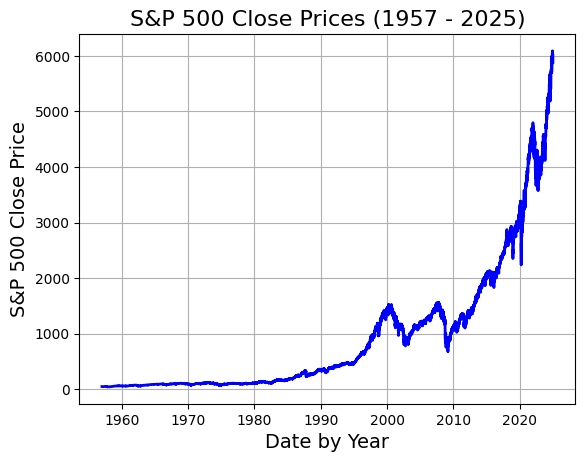

In [ ]:

start_date = "1957-01-01"
end_date = "2025-01-01"

# S&P 500 data (GSPC is the ticker (abbreviation) Yahoo Finance uses for the S&P 500)
sp500_data = yf.download("^GSPC", start=start_date, end=end_date)

# Checks if a column consists of a tuple ex: ('Close', 'GSPC')
# and combines it with Close_GSPC
def flatten_col(col):
    return col[0] if col[1] == "" else f"{col[0]}_{col[1]}"

sp500_data.columns = [flatten_col(col) for col in sp500_data.columns.values]

# Reset index to make the date a seperate column instead of the index
sp500_data.reset_index(inplace=True)

# Renames the columns appropriately
tidy_sp500 = sp500_data[['Date', 'Close_^GSPC']].rename(columns={'Close_^GSPC': 'SP500_Close_Price'})

tidy_sp500df = pd.DataFrame(tidy_sp500)
# Making the dataset into a DataFrame to see some general summary statistics
print(tidy_sp500df.describe())
print('\n')


# Grabbing the head and the tail
print(tidy_sp500.head())
print('....')
print(tidy_sp500.tail())

print('\n')

# Create plot of S&P 500 closing prices
plt.plot(tidy_sp500['Date'], tidy_sp500['SP500_Close_Price'], color='blue', linewidth=2)
plt.xlabel('Date by Year', fontsize=14)
plt.ylabel('S&P 500 Close Price', fontsize=14)
plt.title('S&P 500 Close Prices (1957 - 2025)', fontsize=16)
plt.grid(True)
plt.show()


# FRED Data

The Federal Reserve's FRED database offers a variety of United States economic data. We have started by extracting three very important economic indicators, unemployment, gdp, and inflation (CPI). This will give a sense of what the data provides, however we will bring in a more comprehensive spreadsheet soon. By using this data we can quickly find interesting statistics such as how GDP rates have rose from 934 to 30,000 throughout time. Another interesting data analysis technique we can use is grouping unemployment by decades to conclude that the 1980's was the period with the highest unemployment rate. We can furthermore find general relationships such as CPI and GDP % tending to rise and drop with each other, revealing how inflation comes when the economy is performing well.

In [ ]:
#Import CSV files

unemployment = pd.read_csv("https://raw.githubusercontent.com/schaferkotter-freed/schaferkotter-freed.github.io/main/UNRATE.csv")
gdp = pd.read_csv("https://raw.githubusercontent.com/schaferkotter-freed/schaferkotter-freed.github.io/main/GDP.csv")
cpi = pd.read_csv("https://raw.githubusercontent.com/schaferkotter-freed/schaferkotter-freed.github.io/main/CORESTICKM159SFRBATL.csv")


#Tidy variable names
#CPI (inflation)
cpi = cpi.rename(columns={
    'observation_date': 'Date',
    'CORESTICKM159SFRBATL': 'CPI'
})
#Make pandas know it is a column of dates to make it more interpretable
cpi['Date'] = pd.to_datetime(cpi['Date'])

# GDP
gdp = gdp.rename(columns={
    'observation_date': 'Date',
    'GDP': 'GDP'
})
gdp['Date'] = pd.to_datetime(gdp['Date'])

#Unemployment
unemployment = unemployment.rename(columns={
    'observation_date': 'Date',
    'UNRATE': 'Unemployment_Rate'
})
unemployment['Date'] = pd.to_datetime(unemployment['Date'])


#Merges CPI, GDP, and unemployment rate into 1
merged_df = pd.merge(unemployment, gdp, on='Date', how='inner')
merged_df = pd.merge(merged_df, cpi, on='Date', how='inner')
merged_df.sort_values('Date', inplace=True)

#Find percentage changes between GDP, unemployment rate, and CPI
merged_df['Unemployment_Rate_%'] = merged_df['Unemployment_Rate'].pct_change() * 100
merged_df['GDP_%'] = merged_df['GDP'].pct_change() * 100
merged_df['CPI_%'] = merged_df['CPI'].pct_change() * 100
merged_df = merged_df.dropna()
display(merged_df)
print('\n')

#Stats on GDP
GDP_stats = merged_df['GDP'].describe()
print(GDP_stats)
print('\n')


# Average unemployment rate by decade
merged_df['Year'] = merged_df['Date'].dt.year
merged_df['Decade'] = (merged_df['Year'] // 10) * 10
avg_unemployment_by_decade = merged_df.groupby('Decade')['Unemployment_Rate'].mean()
print(avg_unemployment_by_decade)


,Date,Unemployment_Rate,GDP,CPI,Unemployment_Rate_%,GDP_%,CPI_%
1,1968-04-01,3.5,934.344,4.155828,-5.405405,2.744376,13.800280
2,1968-07-01,3.7,950.825,4.753076,5.714286,1.763911,14.371341
3,1968-10-01,3.4,968.030,5.182592,-8.108108,1.809481,9.036590
4,1969-01-01,3.4,993.337,5.746197,0.000000,2.614278,10.874956
5,1969-04-01,3.4,1009.020,6.505620,0.000000,1.578820,13.216106
...,...,...,...,...,...,...,...
223,2023-10-01,3.9,28296.967,4.882717,11.428571,1.177323,-9.628166
224,2024-01-01,3.7,28624.069,4.601332,-5.128205,1.155961,-5.762878
225,2024-04-01,3.9,29016.714,4.403618,5.405405,1.371730,-4.296886
226,2024-07-01,4.2,29374.914,4.179707,7.692308,1.234461,-5.084705




count      227.000000
mean     10054.636599
std       7631.155360
min        934.344000
25%       3349.147000
50%       8131.408000
75%      15225.540500
max      29719.647000
Name: GDP, dtype: float64


Decade
1960    3.514286
1970    6.190000
1980    7.267500
1990    5.780000
2000    5.492500
2010    6.272500
2020    5.145000
Name: Unemployment_Rate, dtype: float64


# Full FRED Dataset and Unemployment Analysis
Now that we’ve explored a handful of key FRED series, we’ll load the complete set of macroeconomic indicators directly from FRED. This extensive spreadsheet lets us dive into specific data such as housing permits, avg weekly overtime hours, short-term unemployment etc. To pre-process it we removed NAN values, renamed columns, fixed the dates, and removed any unnecessary rows.


In [ ]:
#TIDY DATASET

fred = pd.read_csv("https://raw.githubusercontent.com/schaferkotter-freed/schaferkotter-freed.github.io/main/2025-03.csv")

# In the dataset the first row has the transformation the data went through
# a column with transformation 5, means it is the value in its log form
# drop the sasdate code, because it only contains the word "transform"
tcode_row = fred.iloc[0].drop('sasdate').astype(int)
#Create a dataframe in case we ever have to access the transformations of these values
transform_df = pd.DataFrame({
    'series': tcode_row.index,
    'tcode': tcode_row.values
})
#Remove this dataframe out of data
df = fred.iloc[1:].copy()

#Change date to get in correct form, and make it the index
df.rename(columns={'sasdate': 'Date'}, inplace=True)
df['Date'] = pd.to_datetime(df['Date'], format='%m/%d/%Y')
df.set_index('Date', inplace=True)

# Convert all remaining columns to numeric values
for col in df.columns:
    df[col] = pd.to_numeric(df[col], errors='coerce')

#Because there are so many columns only create mapping values as we need
mapping = {
    'UNRATE': 'Unemployment Rate',
    'UEMP27OV': 'Unemployed 27+ Weeks',
    'UEMPLT5': 'Unemployed 5 Weeks or Less',
    'RPI': 'Real Personal Income',
    'INDPRO': 'Industrial Production Index',
    'UNRATE': 'Unemployment Rate',
    'M1SL': 'M1 Money Stock',
    'CPIAUCSL': 'CPI: All Items',
    'UEMP27OV': 'Unemployed ≥ 27 Weeks',
    'WPSFD49207': 'PPI: Finished Goods',
    'PERMIT': 'Housing Permits (SAAR)',
    'AWOTMAN': 'Avg Weekly Overtime Hours: Mfg',
    'DPCERA3M086SBEA': 'Real Personal Consumption Exp.',
    'BUSINVx': 'Total Business Inventories',
    'CLAIMSx': 'Initial Unemployment Claims',
    'FEDFUNDS': 'Effective Federal Funds Rate',
    'TWEXAFEGSMTHx': 'Trade-Weighted USD Index',
    'IPCONGD': 'IP: Consumer Goods'
}

df.rename(columns=mapping, inplace=True)

In the chart below, we plot monthly S&P 500 closing prices alongside three unemployment series (overall, ≤ 5 weeks, ≥ 27 weeks) from 1990 through today. Since lower unemployment typically signals a stronger economy, we invert each rate and then standardize all four series to place them on a common scale. To avoid big distortions, we’ve also excluded COVID years. The final visualization makes it clear how closely shifts in unemployment align with market movements.

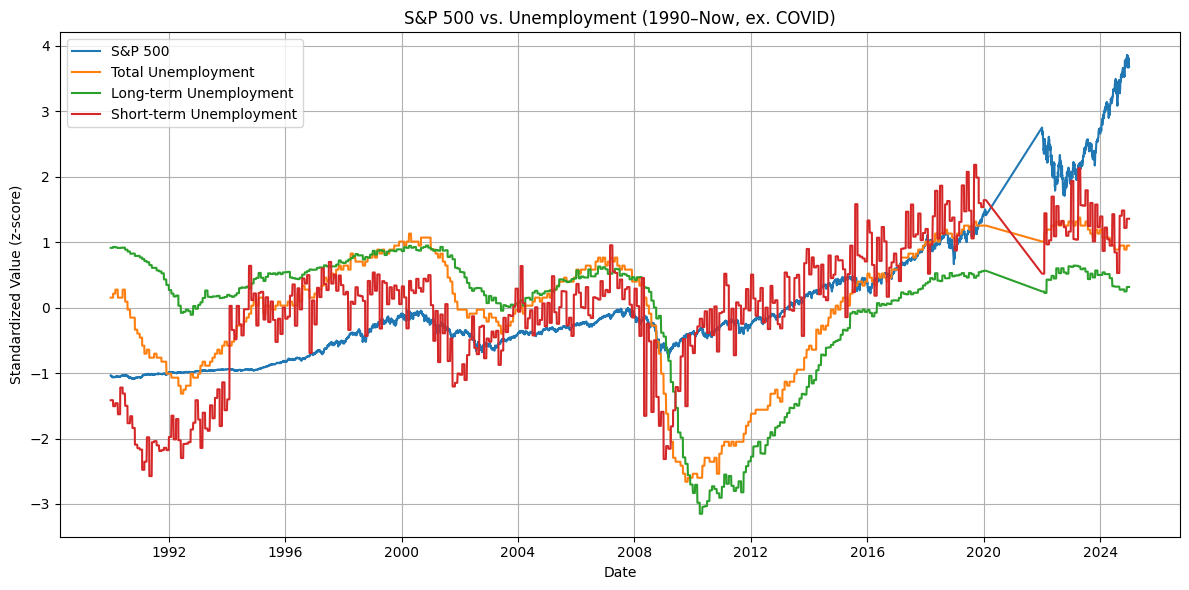

In [ ]:

#1990 to today
start_date = "1990-01-01"
end_date   = pd.Timestamp.today().strftime("%Y-%m-%d")

unemp = (
    df[['Unemployment Rate']]
      .loc[start_date:end_date]
      .reset_index()
);
# Long‑term unemployment (27+ weeks)
uemp27 = (
    df[['Unemployed ≥ 27 Weeks']]
      .loc[start_date:end_date]
      .reset_index()
)
# Short‑term unemployment (<5 weeks)
uemplt5 = (
    df[['Unemployed 5 Weeks or Less']]
      .loc[start_date:end_date]
      .reset_index()
)
# Combine all three into one table
unemp_all = (
    unemp
    .merge(uemp27, on='Date', how='outer')
    .merge(uemplt5, on='Date', how='outer')
    .sort_values('Date')
)

#Merge all the data and have it start at earlier data
merged = pd.merge_asof(
    tidy_sp500df,
    unemp_all,
    on="Date",
    direction="backward"
).dropna()


#Removes COVID from data
covid_start = pd.to_datetime("2020-02-01")
covid_end   = pd.to_datetime("2021-12-31")
mask = (merged["Date"] >= covid_start) & (merged["Date"] <= covid_end)
merged = merged.loc[~mask].copy()


# Standardize all the data
for col in ["SP500_Close_Price", "Unemployment Rate", "Unemployed ≥ 27 Weeks", "Unemployed 5 Weeks or Less"]:
    merged[col] = (merged[col] - merged[col].mean()) / merged[col].std()

# Invert unemployment series to align with S&P
for col in ["Unemployment Rate", "Unemployed ≥ 27 Weeks", "Unemployed 5 Weeks or Less"]:
    merged[col] = -merged[col]


plt.figure(figsize=(12, 6))
plt.plot(merged["Date"], merged["SP500_Close_Price"], label="S&P 500")
plt.plot(merged["Date"], merged["Unemployment Rate"],        label="Total Unemployment")
plt.plot(merged["Date"], merged["Unemployed ≥ 27 Weeks"],    label="Long-term Unemployment")
plt.plot(merged["Date"], merged["Unemployed 5 Weeks or Less"],     label="Short-term Unemployment")

plt.xlabel("Date")
plt.ylabel("Standardized Value (z-score)")
plt.title("S&P 500 vs. Unemployment (1990–Now, ex. COVID)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

We can see that all the unemployment rates follow a similar curve, which makes sense because when unemployment rates are bad, it is obvious that individual companies and overall stock market will suffer. By using three different metrics of unemployment we can obtain multiple conclusions.

Firsty, how the long term unemployment line mirrors the S&P500 line except being pushed further on moments of decline and growth. Additionally the line is curved which can be a good indicator of recessions and times of growth. This is because it takes unemployment more time to smooth out, and is delayed from rises and declines of the overall market. It can create a good estimate on whether the market is going to stay in a decline or reach expansion.

 Secondly, short term unemployment also follows the S&P500, except it is very jagged and constantly switches from above and below the market line. While it would be a bad indicator of long-term growth, the quick drops and rises usually come a month or two before the drops and rises of the market. This can be a good prediction of short term growth, and help decide when to invest.


# S&P500 and Economic Factors Correlation
The chart above clearly shows that there are macroeconomic indicators that follow the S&P 500’s movements. Before we try to forecast stock movements, we first need to pinpoint which economic variables are most related with the market, after all, there’s no point in predicting prices from data that has no relationship to them.

In the following code, we extract fifteen diverse series from our FRED data and calculate each one’s correlation with S&P 500 returns over 1990–2000. By narrowing down our timeframe, we avoid outlier events like wars or big market crashes that might distort the model’s ability to process an accurate correlation.

In [ ]:
start, end = "1990-01-01", "2000-12-31"

pct = pct.loc[start:end]

sp500 = df.loc[start:end, 'S&P 500']

results = {}
for econ_factor in mapping.values():
    if econ_factor in pct.columns:
        # use the sliced sp500 instead of df['S&P 500']
        results[econ_factor] = pct[econ_factor].corr(sp500)

corr_df = pd.DataFrame.from_dict(
    results, orient='index', columns=['Corr_with_SP500']
).sort_values('Corr_with_SP500', ascending=False)

corr_df['AbsCorr'] = corr_df['Corr_with_SP500'].abs()
sorted_corr = corr_df.sort_values('AbsCorr', ascending=False)
print(sorted_corr[['Corr_with_SP500', 'AbsCorr']])

top5_factors = (
    corr_df
    .sort_values('AbsCorr', ascending=False)
    .head(5)
    .index
    .tolist()
)
print(top5_factors)

NameError: name 'pct' is not defined

By tracking the correlation absolute values we can now deeply understand the relationship between these factors and the S&P500. By using this data we can get clear information about which of these are the best indicators to predict market movement. Some observations I could make from this table:


*   Real Personal Consumption Expenditure has highest positive correlation. This makes sense because in the months where consumption accelerates, more spending is done, making businesses and the market in general rise as well.
*   Housing pertmits, short term unemployment and consumer goods production all have a correlation of almost 0, making them bad indicators of market movement and would be unnecessary to use in a prediction model.
*   The M1 money stock has a strong negative correlation. This makes sense because as a simple definition the M1 measures liquidity and how much "ready to spend money" there is. When the stock market is doing well people often invest their on-hand money, however when the stock market is dropping people often hold onto more money and have it in places like their checking accounts.

For our model we have taken the top 5 factors with the most correlation to use as our independent variables.



# Industry ETF Sensitivity to Economic Factors

The S&P500 represents the whole market, however in situations it might be more valuable to look at specific industries. ETF stands for exchange-traded fund, and is a type of investment that holds a basket of assets, in our case these assets will be the companies in each separate industry. By using the same macroeconomic factors as before, we can take different industry ETFs and find the correlation each industry has to each factor.

In [ ]:

# grab sector ETFs and rename
sectors = ['XLB','XLE','XLF','XLI','XLK','XLP','XLU','XLV','XLY','XLC']
sector_names = {
    'XLB': 'Materials (XLB)',
    'XLE': 'Energy (XLE)',
    'XLF': 'Financials (XLF)',
    'XLI': 'Industrials (XLI)',
    'XLK': 'Technology (XLK)',
    'XLP': 'Consumer Staples (XLP)',
    'XLU': 'Utilities (XLU)',
    'XLV': 'Health Care (XLV)',
    'XLY': 'Consumer Discretionary (XLY)',
    'XLC': 'Communication Services (XLC)'
}

# grab economic factors
factors = [
    'Effective Federal Funds Rate',
    'CPI: All Items',
    'Total Business Inventories',
    'Industrial Production Index',
    'IP: Consumer Goods',
    'Trade-Weighted USD Index',
    'M1 Money Stock',
    'Unemployed 5 Weeks or Less',
    'Initial Unemployment Claims',
    'Unemployment Rate'
]

# monthly % changes
factor_pct = df[factors].pct_change().dropna()

# grab start and end and resample
start_date = factor_pct.index.min().strftime('%Y-%m-%d')
end_date   = factor_pct.index.max().strftime('%Y-%m-%d')

#Get monthly percent change of etfs
sec_daily = yf.download(sectors, start=start_date, end=end_date, progress=False)['Close']
sec_monthly = sec_daily.resample('MS').first()
sec_pct     = sec_monthly.pct_change().dropna()

#Find correlation between factors and sectors
common = sec_pct.join(factor_pct, how='inner')
corr_matrix = common[sectors + factors].corr().loc[sectors, factors]

plt.figure(figsize=(12, 8))
sns.heatmap(
    corr_matrix,
    annot=True,         # draw the correlation value in each cell
    fmt=".2f",          # two decimal places
    cmap="vlag",        # color of map
    vmin=-1, vmax=1,    # color scale to -1 to +1
    xticklabels=factors,
    yticklabels=[sector_names[t] for t in sectors]
)

plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)  # keep sector names horizontal

plt.title('Sector ETF vs. Economic Factor Correlations')
plt.tight_layout()
plt.show()

As seen above, each industry reacts differently to shifts in the economy, which can be a valuable insight to help investors adjust portfolios ahead of forecasted changes. For example, if unemployment is expected to rise, one might shift investments to sectors like technology, which tend to be less sensitive to job-market swings, and sell stocks in more cyclical areas such as finance.

Another interesting finding is that the Energy sector shows the strongest correlation with CPI. CPI is a good indicator of inflation, and energy represents things like oil, and gas prices. This observation makes it clear that a spike in inflation often mirror jumps in energy prices. By understanding sector-specific sensitivities, investors can position themselves to better adjust to economic risks or capitalize on future trends.


# Economic Correlations

In the data above, we analyzed how FRED data correlates with the stock market and different industry ETFs. However, if we want to make a prediction model we need to choose the best indicators to predict the stock market. Although we found the factors with the most correlation we have to make sure they do not have a strong correlation with each other. For example, if a certain industry's movement is most dependent on long term unemployment and average unemployment rates, it does not make sense to use both in a model. Because they have such a high correlation with each other, and represent practically the same thing it would make sense to only pick one of these, or else the model would become very dependent on unemployment rates.

Below we created a heat map to analyze correlations our top 5 economic factors have with each other to confirm that the variables are the best predictors.

In [ ]:
newDf = fred.iloc[1:].copy() # new df with no manipulation

factor_mapping = { # various factors, since it would be a lot to analyze them all
    'UEMP27OV': 'Unemployed 27+ Weeks',
    'CPIAUCSL': 'CPI: All Items',
    'FEDFUNDS': 'Federal Funds Rate',
    'M1SL': 'M1 Money Stock',
    'DPCERA3M086SBEA': 'Real Personal Consumption Exp.'

}


newDf.rename(columns=factor_mapping, inplace=True)
factor_cols = list(factor_mapping.values())
pct_changes = newDf[factor_cols].pct_change().dropna()
corr_matrix = pct_changes.corr()
economic_factor_corr = corr_matrix.loc[factor_cols]

# heatmap
plt.figure(figsize=(10, 4))
sns.heatmap(economic_factor_corr, annot=True, fmt=".2f", cmap='coolwarm', linewidths=0.5)
plt.title('Correlation Between Economic Factors', pad=20)
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

Although M1 Money Stock and Real Personal Consumption Expenditures show some correlation, the relationship is not extreme. Given the limited overlap, we’ll proceed with these five indicators as our independent variables in the final prediction model.

# Bring in Datasets

In [ ]:
fred = pd.read_csv("https://raw.githubusercontent.com/schaferkotter-freed/schaferkotter-freed.github.io/main/2025-03.csv")

# In the dataset the first row has the transformation the data went through
# a column with transformation 5, means it is the value in its log form
# drop the sasdate code, because it only contains the word "transform"
tcode_row = fred.iloc[0].drop('sasdate').astype(int)
#Create a dataframe in case we ever have to access the transformations of these values
transform_df = pd.DataFrame({
    'series': tcode_row.index,
    'tcode': tcode_row.values
})
#Remove this dataframe out of data
df = fred.iloc[1:].copy()

#Change date to get in correct form, and make it the index
df.rename(columns={'sasdate': 'Date'}, inplace=True)
df['Date'] = pd.to_datetime(df['Date'], format='%m/%d/%Y')
df.set_index('Date', inplace=True)

# Convert all remaining columns to numeric values
for col in df.columns:
    df[col] = pd.to_numeric(df[col], errors='coerce')

#Because there are so many columns only create mapping values as we need
mapping = {
    'UNRATE': 'Unemployment Rate',
    'UEMP27OV': 'Unemployed 27+ Weeks',
    'UEMPLT5': 'Unemployed 5 Weeks or Less',
    'RPI': 'Real Personal Income',
    'INDPRO': 'Industrial Production Index',
    'UNRATE': 'Unemployment Rate',
    'M1SL': 'M1 Money Stock',
    'CPIAUCSL': 'CPI: All Items',
    'UEMP27OV': 'Unemployed ≥ 27 Weeks',
    'WPSFD49207': 'PPI: Finished Goods',
    'PERMIT': 'Housing Permits (SAAR)',
    'AWOTMAN': 'Avg Weekly Overtime Hours: Mfg',
    'DPCERA3M086SBEA': 'Real Personal Consumption Exp.',
    'BUSINVx': 'Total Business Inventories',
    'CLAIMSx': 'Initial Unemployment Claims',
    'FEDFUNDS': 'Effective Federal Funds Rate',
    'TWEXAFEGSMTHx': 'Trade-Weighted USD Index',
    'IPCONGD': 'IP: Consumer Goods'
}

df.rename(columns=mapping, inplace=True)

start_date = "1957-01-01"
end_date = "2025-01-01"

# S&P 500 data (GSPC is the ticker (abbreviation) Yahoo Finance uses for the S&P 500)
sp500_data = yf.download("^GSPC", start=start_date, end=end_date)

# Checks if a column consists of a tuple ex: ('Close', 'GSPC')
# and combines it with Close_GSPC
def flatten_col(col):
    return col[0] if col[1] == "" else f"{col[0]}_{col[1]}"

sp500_data.columns = [flatten_col(col) for col in sp500_data.columns.values]

# Reset index to make the date a seperate column instead of the index
sp500_data.reset_index(inplace=True)

# Renames the columns appropriately
tidy_sp500 = sp500_data[['Date', 'Close_^GSPC']].rename(columns={'Close_^GSPC': 'SP500_Close_Price'})

tidy_sp500df = pd.DataFrame(tidy_sp500)
# Making the dataset into a DataFrame to see some general summary statistics

# Machine Learning Models

Our idea is to build a general S&P 500 forecasting model using a linear regression model that accounts for the key macroeconomic factors we have discovered throughout this project to see how well the broader economy alone can explain stock movements. We align each series to monthly S&P 500 closes, split the data into training and validation sets, and use a pipeline (vectorization, standard scaling, linear regression) with a 4 fold cross-validation to assess performance. Additionally we have picked a specific time frame so our model is not skewed with very old data. Our main challenge is that markets respond to many non-economic factors as well, so perfect accuracy is unlikely but this framework lets us quantify how strong the relationship is.


In [ ]:

#1980 to 2010
start_date = "1990-01-01"
end_date   = "2010-01-01"

#Combines the 5 economic factors with the most correlation
econ_all = (
    df[top5_factors]
    .loc[start_date:end_date]
    .reset_index()
    .sort_values('Date')
)

#FRED has specific days of the month so need to merge based on the one entry each dataset shares per month

# 1) turn Date into index and grab month-end closes
sp500_monthly = (
    tidy_sp500df
      .set_index('Date')['SP500_Close_Price']
      .resample('ME')     # month‐end frequency
      .last()            # take last trading‐day close
      .to_frame()
      .reset_index()
)

# 2) now econ_all is already monthly (Date at month‐end or month‐start)
#    might want to align it to month‐end as well:
econ_monthly = econ_all.copy()
econ_monthly['Date'] = econ_monthly['Date'].dt.to_period('M').dt.to_timestamp('M')

# 3) simple merge on the identical Date
merged_monthly = pd.merge(
    sp500_monthly,
    econ_monthly,
    on='Date',
    how='inner'
)

features = ["CPI: All Items", "Unemployed ≥ 27 Weeks", "Real Personal Consumption Exp.", "Effective Federal Funds Rate", "M1 Money Stock"]
y = merged_monthly["SP500_Close_Price"].values
X_dicts = merged_monthly[features].to_dict(orient="records")

# 1) Split into train/validation (no shuffle so time order is preserved)
X_train_dicts, X_val_dicts, y_train, y_val = train_test_split(
    X_dicts, y, test_size=0.4, shuffle=False
)

# 2) Vectorize
vec = DictVectorizer(sparse=False)
scaler = StandardScaler()
model = LinearRegression()
pipeline = Pipeline([("vectorizer", vec), ("scaler", scaler), ("fit", model)])

cv_results = cross_validate(pipeline, X_train_dicts, y_train, cv=4,
                                scoring='neg_mean_absolute_error',
                                return_train_score=True)

pipeline.fit(X_train_dicts, y_train)
avg_train_mae = -np.mean(cv_results['train_score'])
avg_val_mae = -np.mean(cv_results['test_score'])
print(avg_train_mae, avg_val_mae)

Although the model has a solid training and validation accuracy we are creating the model based on a very small amount of data. Although it is for 30 years, it is monthly data giving us only about 360 entries to work with to predict the whole stock market.

In order to see how well it can actually predict a price we will take a month out of our dataset. We will provide the model the real economic data at the time, and see if it can predict an accurate price.

In [ ]:

test_row = df.iloc[615]
print(test_row)
test_var = test_row[features].to_dict()
predicted_sp500 = pipeline.predict([test_var])[0]
row = tidy_sp500[tidy_sp500["Date"] == "2010-03-30"]
print("Real value:", row["SP500_Close_Price"].iloc[0])
print("Predicted value:", predicted_sp500)



The model’s forecast is extremely unaccurate from the actual S&P 500 value, highlighting just how challenging it is to predict the market. Even with strong economic indicators, countless other variables influence stock prices, making a pure macro-based prediction model imprecise.

# Conclusion

Although our analysis confirms that S&P 500 prices and macroeconomic indicators move together to some degree, it’s clear that a prediction model built solely on those factors is not viable. These indicators are only one piece of a more complex picture where even when we project two months beyond our training window, the model’s price estimates are wildly inaccurate.

That being said, this project still offers real value. With industry‐specific correlation data, one could develop a risk‐assessment tool that simulates portfolio performance under various macroeconomic scenarios. Alternatively, a more broad classification model could increase the accuracy, flagging whether incoming economic signals are likely to bring a recession or an inflationary period.

Overall, this project deepened our understanding of how economics and the stock market interact. We gained experience extracting and analyzing large public data sets, uncovered observations we had never considered, and, most importantly, learned firsthand why the stock market remains so notoriously difficult to forecast.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
!pip install nbconvert  # Install nbconvert
!pip install --upgrade jinja2

# Ensure file exists and the path is correct
!ls /content/drive/MyDrive/Colab\ Notebooks/FinalTutorial.ipynb

# Convert the notebook
!jupyter nbconvert --to html "/content/drive/MyDrive/Colab Notebooks/FinalTutorial.ipynb" # Run with correct path